### Import Libraries

In [47]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import cufflinks as cf
import plotly.io as pio
import pandasql
from glob import glob

### Load Data Files

In [39]:
filenames = glob('Data Sets/yammer_events*.csv')
df = [pd.read_csv(f) for f in filenames]

yammer_events = df[0].append(df[1])
yammer_events = yammer_events.append(df[2])

In [40]:
yammer_emails = pd.read_csv('Data Sets/yammer_emails.csv')
roll_up = pd.read_csv('Data Sets/dimension_rollup_periods.csv')
yammer_users = pd.read_csv('Data Sets/yammer_users.csv')

### Case Problem
Product team noticed a drop in Weekly active users, our goal is to determine why there was a dip in engagement in the chart below: 

In [41]:
weekly_active_users = pandasql.sqldf("SELECT strftime('%Y-%m-%d', occurred_at,'weekday 0','-6 days') as week,\
                                             COUNT(DISTINCT user_id) as weekly_active_users\
                                      FROM yammer_events\
                                      WHERE event_type='engagement'\
                                      AND occurred_at >= '2014-05-01'\
                                      GROUP BY 1\
                                      ORDER BY 1;", globals()) 
weekly_active_users.head()

,week,weekly_active_users
0,2014-04-28,701
1,2014-05-05,1054
2,2014-05-12,1094
3,2014-05-19,1147
4,2014-05-26,1113


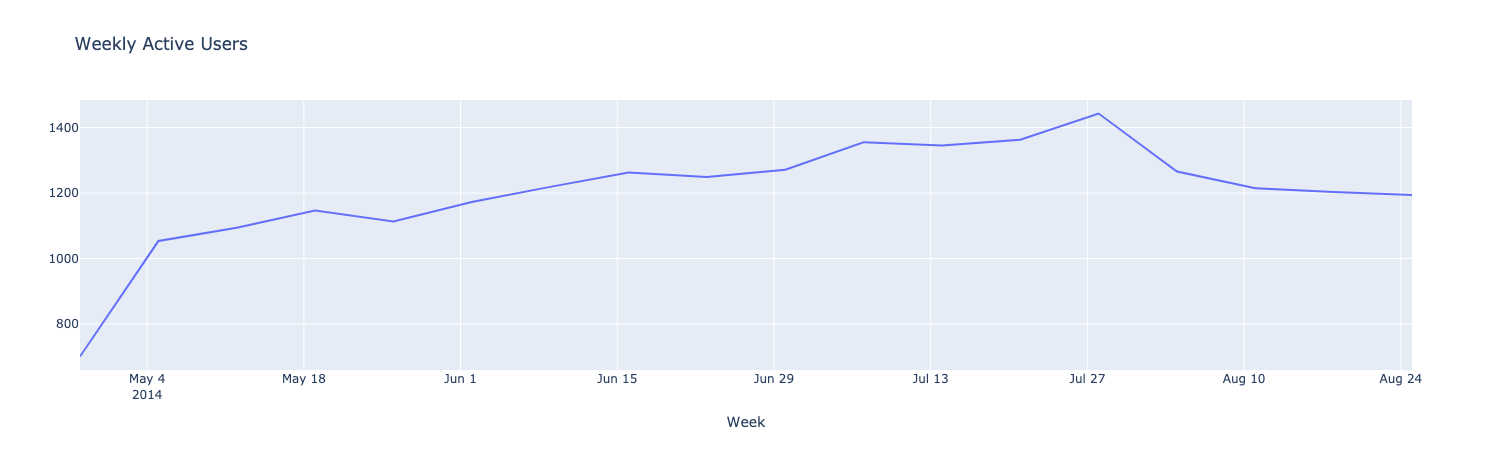

In [55]:
date = weekly_active_users['week']
count_users = weekly_active_users['weekly_active_users']

fig = go.Figure()
fig.add_trace(go.Scatter(x=date, y=count_users,mode='lines',name='number of users'))

fig.update_layout(title='Weekly Active Users',xaxis_title='Week')

pio.write_html(fig, file='Figures/Weekly_Active_Users.html',include_plotlyjs='cdn',default_width='60%', default_height='60%')

# pio.show(fig)
iplot(fig)

### Test Hypotheses

##### 1. Engagement by Factors of Time
Do we see the engagement levels gradually decreasing over time or only a one time sudden decrease? Is the decrease specific to certain days of the week or certain times of the day?

<b>Daily Engagement Rate</b>

In [7]:
daily_eng = pandasql.sqldf("SELECT strftime('%Y-%m-%d', occurred_at) as date,\
                                   (CAST(COUNT(*) as FLOAT)/ CAST(COUNT(DISTINCT user_id) as FLOAT)) as engagement_rate\
                            FROM yammer_events\
                            WHERE event_type='engagement'\
                            AND occurred_at >= '2014-05-01'\
                            GROUP by 1\
                            ORDER by 1;", globals()) 
daily_eng.head()

,date,engagement_rate
0,2014-05-01,9.808874
1,2014-05-02,10.765363
2,2014-05-03,8.903448
3,2014-05-04,8.734177
4,2014-05-05,10.050584


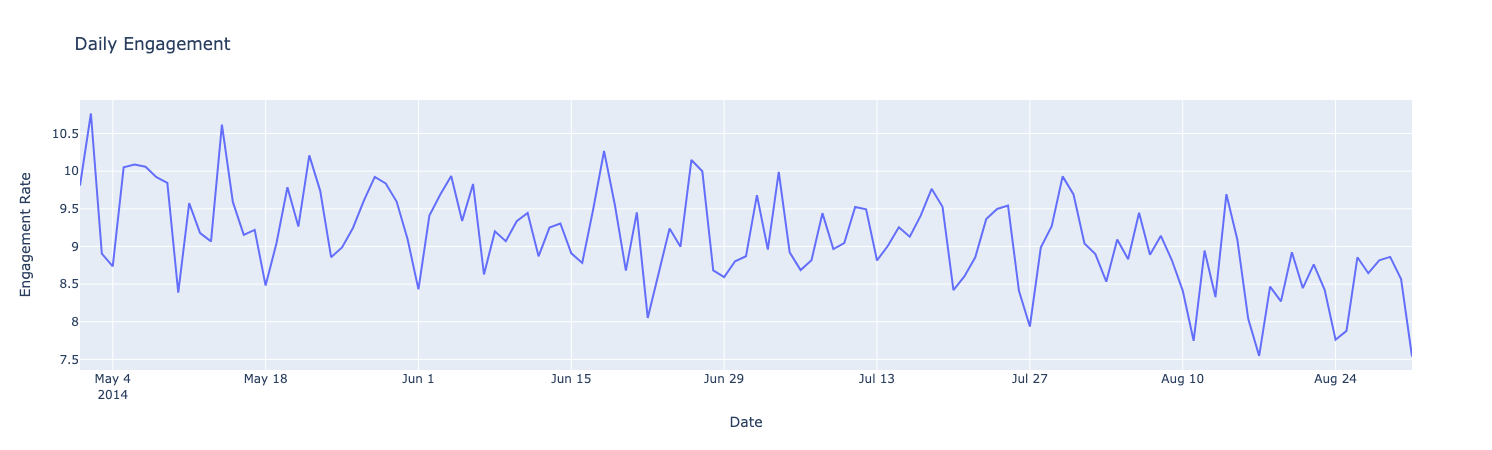

In [9]:
date = daily_eng['date']
engagement_rate = daily_eng['engagement_rate']

fig = go.Figure()
fig.add_trace(go.Scatter(x=date, y=engagement_rate,mode='lines',name='engagement_rate'))

fig.update_layout(title='Daily Engagement',xaxis_title='Date',yaxis_title='Engagement Rate')

pio.write_html(fig, file='Figures/Daily_Engagement_Rate.html',include_plotlyjs='cdn',default_width='60%', default_height='60%')
pio.show(fig)

<b>Engagement Rate by Day of Week</b>

In [11]:
day_of_week = pandasql.sqldf("SELECT strftime('%w', occurred_at) as date,\
                                     CASE WHEN strftime('%w', occurred_at) = '0' THEN 'Sun'\
                                          WHEN strftime('%w', occurred_at) = '1' THEN 'Mon'\
                                          WHEN strftime('%w', occurred_at) = '2' THEN 'Tue'\
                                          WHEN strftime('%w', occurred_at) = '3' THEN 'Wed'\
                                          WHEN strftime('%w', occurred_at) = '4' THEN 'Thu'\
                                          WHEN strftime('%w', occurred_at) = '5' THEN 'Fri'\
                                          WHEN strftime('%w', occurred_at) = '6' THEN 'Sat'\
                                     END as week_day,\
                                     (CAST(COUNT(*) as FLOAT)/ CAST(COUNT(DISTINCT user_id) as FLOAT)) as engagement_rate\
                             FROM yammer_events\
                             where event_type='engagement'\
                             and occurred_at >= '2014-05-01'\
                             group by 1\
                             order by 1;", globals()) 
day_of_week.head()

,date,week_day,engagement_rate
0,0,Sun,9.633461
1,1,Mon,14.766006
2,2,Tue,16.405758
3,3,Wed,17.235331
4,4,Thu,17.961189


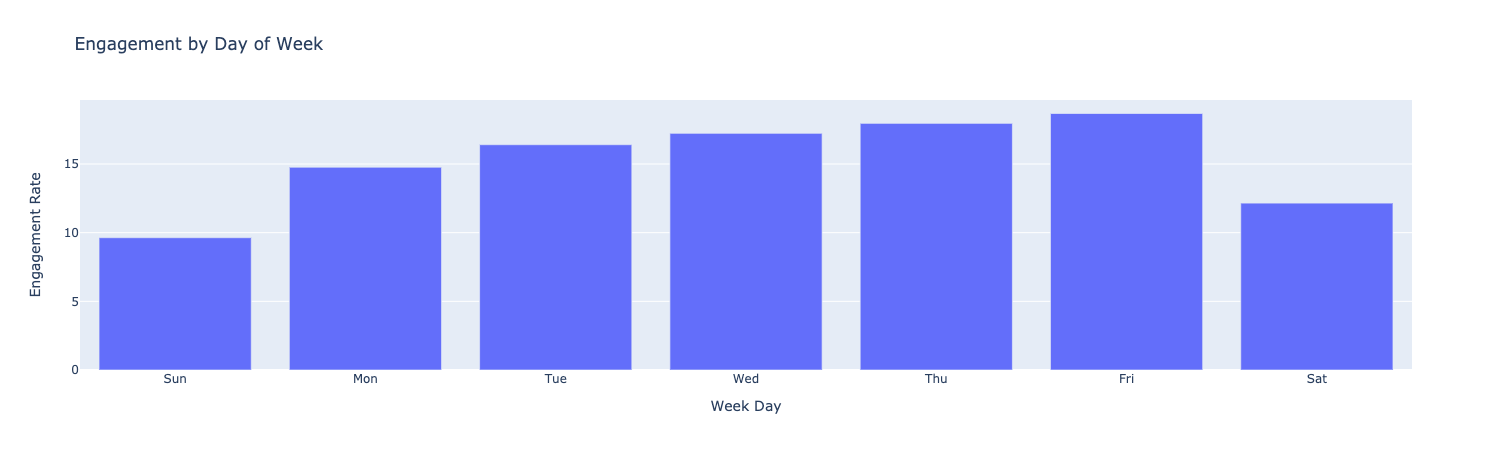

In [13]:
date = day_of_week['week_day']
engagement_rate = day_of_week['engagement_rate']

fig = go.Figure()
fig.add_trace(go.Bar(x=date, y=engagement_rate,name='engagement_rate'))

fig.update_layout(title='Engagement by Day of Week',xaxis_title='Week Day',yaxis_title='Engagement Rate')

pio.write_html(fig, file='Figures/Engagement_by_Day_of_Week.html',include_plotlyjs='cdn',default_width='60%', default_height='60%')
pio.show(fig)

<b>Engagement Rate by Time of Day</b>

In [14]:
eng_by_time = pandasql.sqldf("SELECT strftime('%H', occurred_at) as time,\
                                     (CAST(COUNT(*) as FLOAT)/ CAST(COUNT(DISTINCT user_id) as FLOAT)) as engagement_rate\
                              FROM yammer_events\
                              WHERE event_type='engagement'\
                              AND occurred_at >= '2014-05-01'\
                              GROUP BY 1\
                              ORDER BY 1;", globals()) 
eng_by_time.head()

,time,engagement_rate
0,00,9.787736
1,01,9.410628
2,02,8.578125
3,03,9.088710
4,04,9.169014


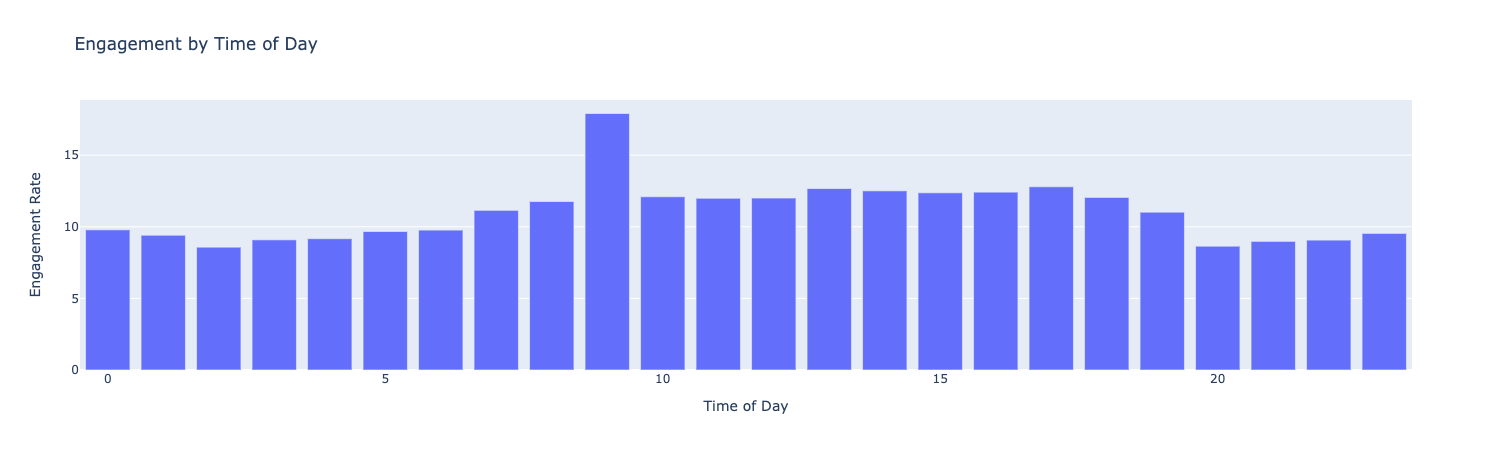

In [15]:
time = eng_by_time['time']
engagement_rate = eng_by_time['engagement_rate']

fig = go.Figure()
fig.add_trace(go.Bar(x=time, y=engagement_rate))

fig.update_layout(title='Engagement by Time of Day',xaxis_title='Time of Day',yaxis_title='Engagement Rate')

pio.write_html(fig, file='Figures/Engagement_by_Time_of_Day.html',include_plotlyjs='cdn',default_width='60%', default_height='60%')
pio.show(fig)

##### 2. Growth/ Activation Rate
Since the drop in users were gradual over time and not localized to a particular day of the week or time of day, we should now move on and identify if there is an issue with acquiring new users or activating new users

In [16]:
activation_rate = pandasql.sqldf("SELECT strftime('%Y-%m-%d', created_at) as date,\
                                         COUNT(*) as all_users,\
                                         COUNT(DISTINCT CASE WHEN activated_at IS NOT NULL THEN user_id ELSE NULL END) as activated_users \
                                  FROM yammer_users\
                                  WHERE created_at >= '2014-05-01'\
                                  GROUP BY 1\
                                  ORDER BY 1;", globals()) 
activation_rate.head()

,date,all_users,activated_users
0,2014-05-01,73,34
1,2014-05-02,57,30
2,2014-05-03,19,8
3,2014-05-04,22,9
4,2014-05-05,58,24


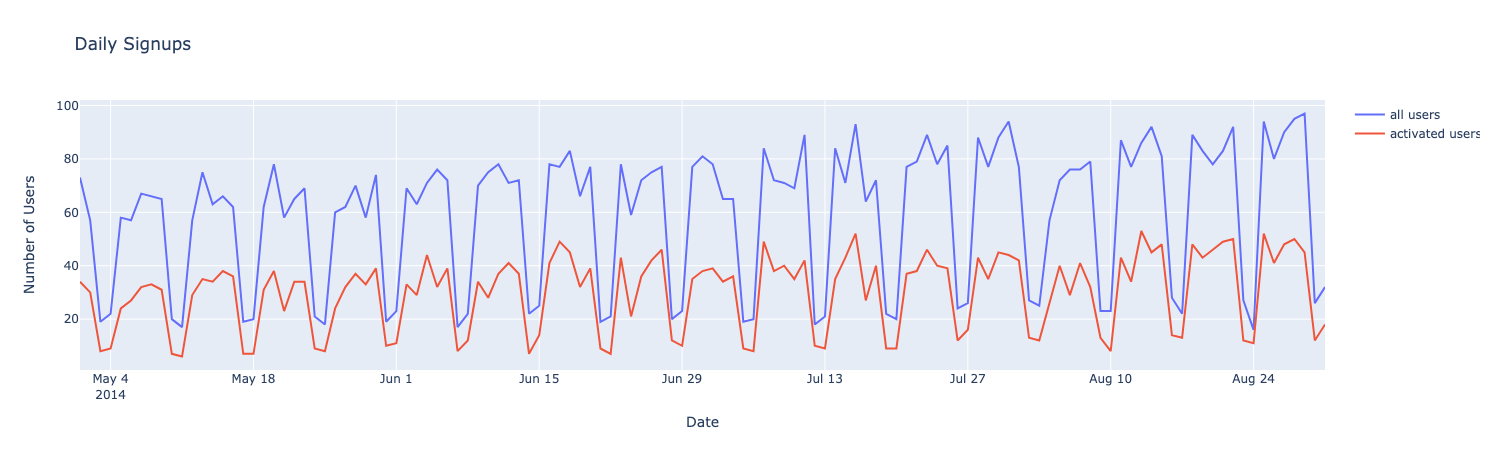

In [17]:
date = activation_rate['date']
all_users = activation_rate['all_users']
activated_users = activation_rate['activated_users']

fig = go.Figure()
fig.add_trace(go.Scatter(x=date, y=all_users,mode='lines',name='all users'))
fig.add_trace(go.Scatter(x=date, y=activated_users,mode='lines',name='activated users'))

fig.update_layout(title='Daily Signups',xaxis_title='Date',yaxis_title='Number of Users')

pio.write_html(fig, file='Figures/Daily_Signups.html',include_plotlyjs='cdn',default_width='60%', default_height='60%')
pio.show(fig)

##### 3. Cohort Analysis
Since activation rate is normal, we know the issue is not associated with growth (acquiring new users). The drop will likely be due to disengagement from existing users, so we should do a cohort analysis allowing us to compare users at different life stages with Yammer.

In [18]:
cohort_age = pandasql.sqldf("SELECT f.week as week,\
                                    COUNT(DISTINCT CASE WHEN f.user_age > 70 THEN f.user_id ELSE NULL END) as '10+ weeks old',\
                                    COUNT(DISTINCT CASE WHEN f.user_age < 70 AND f.user_age >= 63 THEN f.user_id ELSE NULL END) as '9 weeks old',\
                                    COUNT(DISTINCT CASE WHEN f.user_age < 63 AND f.user_age >= 56 THEN f.user_id ELSE NULL END) as '8 weeks old',\
                                    COUNT(DISTINCT CASE WHEN f.user_age < 56 AND f.user_age >= 49 THEN f.user_id ELSE NULL END) as '7 weeks old',\
                                    COUNT(DISTINCT CASE WHEN f.user_age < 49 AND f.user_age >= 42 THEN f.user_id ELSE NULL END) as '6 weeks old',\
                                    COUNT(DISTINCT CASE WHEN f.user_age < 42 AND f.user_age >= 35 THEN f.user_id ELSE NULL END) as '5 weeks old',\
                                    COUNT(DISTINCT CASE WHEN f.user_age < 35 AND f.user_age >= 28 THEN f.user_id ELSE NULL END) as '4 weeks old',\
                                    COUNT(DISTINCT CASE WHEN f.user_age < 28 AND f.user_age >= 21 THEN f.user_id ELSE NULL END) as '3 weeks old',\
                                    COUNT(DISTINCT CASE WHEN f.user_age < 21 AND f.user_age >= 14 THEN f.user_id ELSE NULL END) as '2 weeks old',\
                                    COUNT(DISTINCT CASE WHEN f.user_age < 14 AND f.user_age >= 7  THEN f.user_id ELSE NULL END) as '1 week old',\
                                    COUNT(DISTINCT CASE WHEN f.user_age < 7 THEN f.user_id ELSE NULL END) as 'less than a week old'\
                             FROM\
                                 (SELECT strftime('%Y-%m-%d', e.occurred_at,'weekday 0','-6 days') as week,\
                                         CAST(u.user_id as INT) as user_id,\
                                         CAST((julianday('2014-09-01') - julianday(u.activated_at)) as INT) as user_age\
                                  FROM yammer_users u\
                                    JOIN yammer_events e\
                                      ON e.user_id = u.user_id\
                                  WHERE e.event_type = 'engagement'\
                                  AND e.event_name = 'login'\
                                  AND e.occurred_at >= '2014-05-01'\
                                  AND u.activated_at IS NOT NULL) f\
                            GROUP BY 1\
                            ORDER BY 1\
                              ;", globals()) 
cohort_age.head()

,week,10+ weeks old,9 weeks old,8 weeks old,7 weeks old,6 weeks old,5 weeks old,4 weeks old,3 weeks old,2 weeks old,1 week old,less than a week old
0,2014-04-28,701,0,0,0,0,0,0,0,0,0,0
1,2014-05-05,1054,0,0,0,0,0,0,0,0,0,0
2,2014-05-12,1094,0,0,0,0,0,0,0,0,0,0
3,2014-05-19,1147,0,0,0,0,0,0,0,0,0,0
4,2014-05-26,1113,0,0,0,0,0,0,0,0,0,0


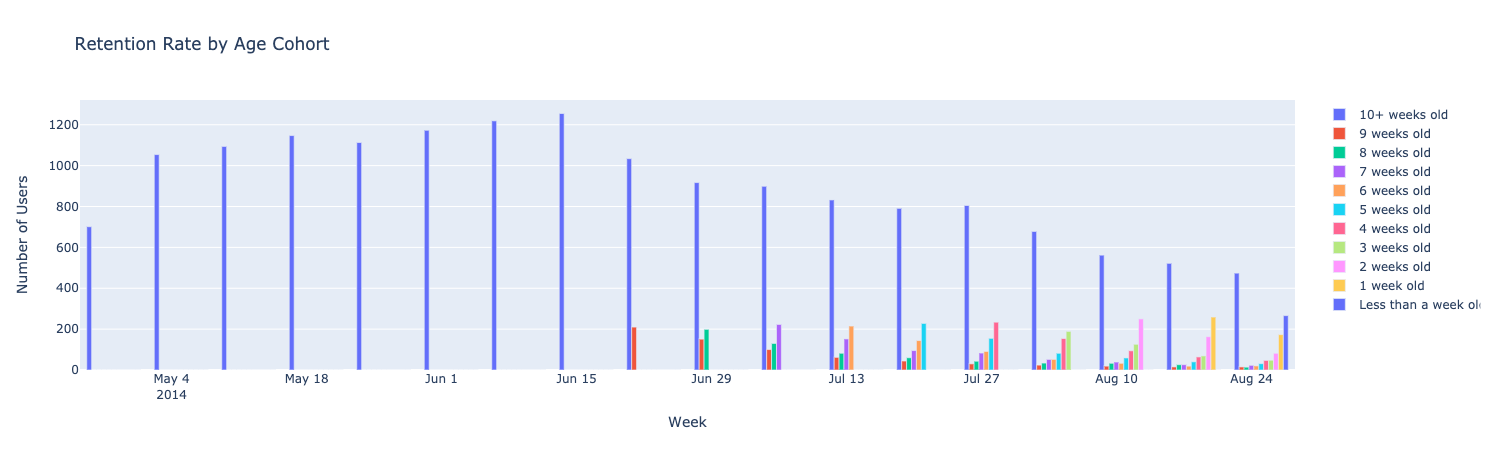

In [19]:
x=cohort_age['week']
y1=cohort_age['10+ weeks old']
y2=cohort_age['9 weeks old']
y3=cohort_age['8 weeks old']
y4=cohort_age['7 weeks old']
y5=cohort_age['6 weeks old']
y6=cohort_age['5 weeks old']
y7=cohort_age['4 weeks old']
y8=cohort_age['3 weeks old']
y9=cohort_age['2 weeks old']
y10=cohort_age['1 week old']
y11=cohort_age['less than a week old']

fig = go.Figure(data=[
      go.Bar(name='10+ weeks old', x=x, y=y1),
      go.Bar(name='9 weeks old', x=x, y=y2),
      go.Bar(name='8 weeks old', x=x, y=y3),
      go.Bar(name='7 weeks old', x=x, y=y4),
      go.Bar(name='6 weeks old', x=x, y=y5),
      go.Bar(name='5 weeks old', x=x, y=y6),
      go.Bar(name='4 weeks old', x=x, y=y7),
      go.Bar(name='3 weeks old', x=x, y=y8),
      go.Bar(name='2 weeks old', x=x, y=y9),
      go.Bar(name='1 week old', x=x, y=y10),
      go.Bar(name='Less than a week old', x=x, y=y11),
])

fig.update_layout( title='Retention Rate by Age Cohort',xaxis_title='Week ',yaxis_title='Number of Users',barmode='group')

pio.write_html(fig, file='Figures/Retention_Rate_by_Age_Cohort.html',include_plotlyjs='cdn',default_width='60%', default_height='60%')
pio.show(fig)

##### 4. Engagement by Type of Events
By looking at the assumed UX flow, there are four major types of engagement events:
- signing up as a new user
- logging in to homepage as an existing user
- inbox and message related engagement
- search and click related engagement

We want to group these together, and see if there is a more pronounced drop in engagement for either groups

In [20]:
events = pandasql.sqldf("SELECT DISTINCT event_type, event_name FROM yammer_events ORDER BY 1,2;", globals()) 
events

,event_type,event_name
0,engagement,home_page
1,engagement,like_message
2,engagement,login
3,engagement,search_autocomplete
4,engagement,search_click_result_1
5,engagement,search_click_result_10
6,engagement,search_click_result_2
7,engagement,search_click_result_3
8,engagement,search_click_result_4
9,engagement,search_click_result_5


In [21]:
weekly_type = pandasql.sqldf("SELECT strftime('%Y-%m-%d', occurred_at,'weekday 0','-6 days') as week,\
                                     COUNT(CASE WHEN event_name IN ('complete_signup','create_user','enter_email','enter_info') THEN user_id ELSE NULL END) AS 'sign up', \
                                     COUNT(CASE WHEN event_name IN ('login') THEN user_id ELSE NULL END) AS 'login', \
                                     COUNT(CASE WHEN event_name IN ('home_page') THEN user_id ELSE NULL END) AS 'homepage', \
                                     COUNT(CASE WHEN event_name IN ('view_inbox','like_message','send_message') THEN user_id ELSE NULL END) AS 'message', \
                                     COUNT(CASE WHEN event_name IN ('search_autocomplete','search_click_result_1','search_click_result_2','search_click_result_3','search_click_result_4','search_click_result_5','search_click_result_6','search_click_result_7','search_click_result_8','search_click_result_9','search_click_result_10') THEN user_id ELSE NULL END) AS 'search click'\
                             FROM yammer_events\
                             where occurred_at >= '2014-05-01'\
                             GROUP BY 1\
                             ORDER BY 1\
                             ;", globals()) 
weekly_type.head()

,week,sign up,login,homepage,message,search click
0,2014-04-28,440,967,2546,4071,767
1,2014-05-05,884,1999,5113,8258,1409
2,2014-05-12,960,2021,5032,7980,1374
3,2014-05-19,955,2088,5217,8270,1571
4,2014-05-26,978,1995,4978,7982,1497


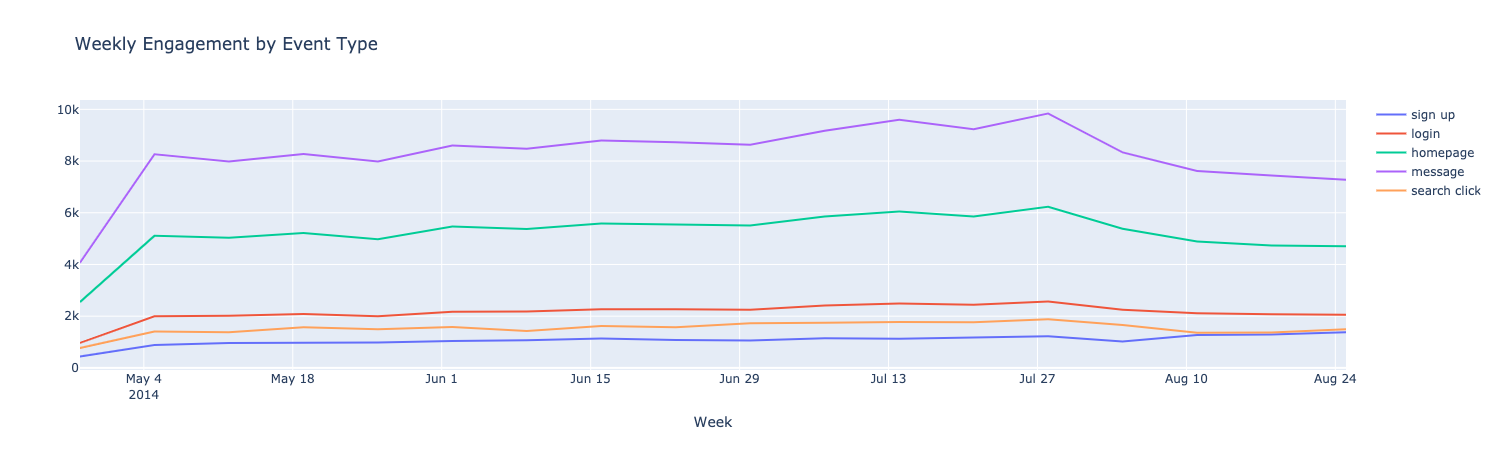

In [22]:
week = weekly_type['week']
signup = weekly_type['sign up']
login = weekly_type['login']
homepage = weekly_type['homepage']
message = weekly_type['message']
search_click = weekly_type['search click']

fig = go.Figure()
fig.add_trace(go.Scatter(x=week, y=signup,mode='lines',name='sign up'))
fig.add_trace(go.Scatter(x=week, y=login,mode='lines',name='login'))
fig.add_trace(go.Scatter(x=week, y=homepage,mode='lines',name='homepage'))
fig.add_trace(go.Scatter(x=week, y=message,mode='lines',name='message'))
fig.add_trace(go.Scatter(x=week, y=search_click,mode='lines',name='search click'))

fig.update_layout(title='Weekly Engagement by Event Type',xaxis_title='Week')

pio.write_html(fig, file='Figures/Weekly_Engagement_by_Event_Type.html',include_plotlyjs='cdn',default_width='60%', default_height='60%')
pio.show(fig)

##### 5. Engagement by Region
Knowing that growth is normal, and the drop in engagement is likely due to older users - we'd now want to narrow down some more details.
If the drop is localized to a particular region then there could be an issue related to that.

In [23]:
Top5_Regions = pandasql.sqldf("SELECT location,\
                                      COUNT(DISTINCT user_id) as count_users\
                               FROM yammer_events\
                               where event_type='engagement'\
                               and occurred_at >= '2014-05-01'\
                               GROUP BY 1\
                               ORDER BY 2 DESC\
                               LIMIT 5\
                               ;", globals()) 

In [24]:
engagement_region = pandasql.sqldf("SELECT strftime('%Y-%m-%d', occurred_at,'weekday 0','-6 days') as week,\
                                    location,\
                                    count(distinct user_id) as active_users\
                                    FROM yammer_events\
                                    where location in (select location from Top5_Regions)\
                                    and event_type='engagement'\
                                    and occurred_at >= '2014-05-01'\
                                    group by 1,2\
                                    order by 1;", globals()) 
engagement_region.head()

,week,location,active_users
0,2014-04-28,France,34
1,2014-04-28,Germany,42
2,2014-04-28,Japan,47
3,2014-04-28,United Kingdom,33
4,2014-04-28,United States,203


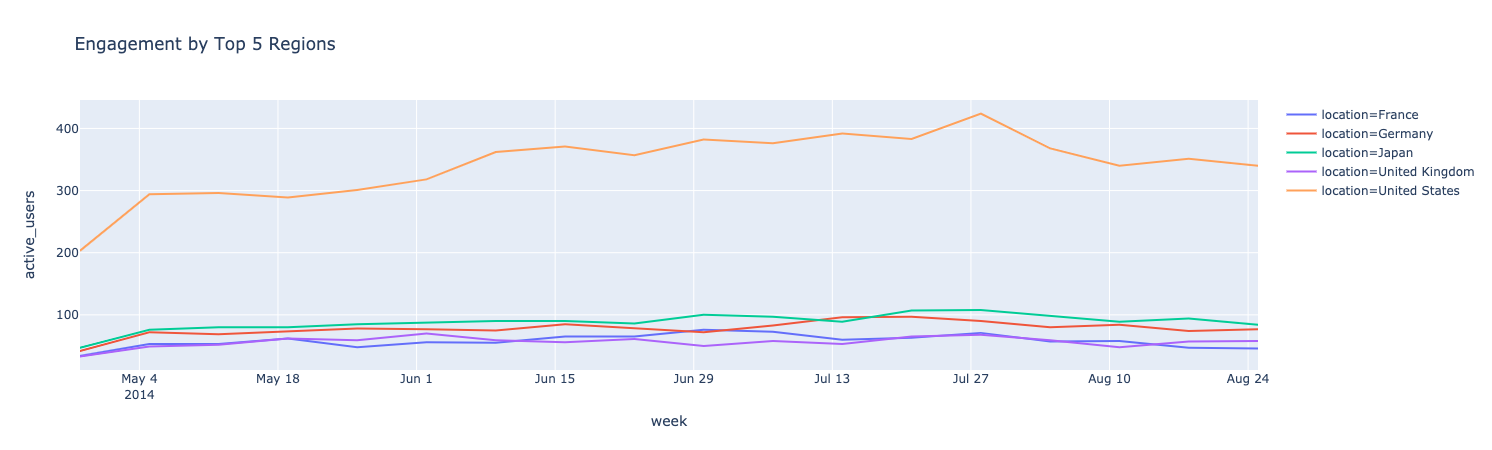

In [25]:
fig = px.line(engagement_region, x='week', y='active_users', color="location", title='Engagement by Top 5 Regions')

pio.write_html(fig, file='Figures/Engagement_by_Region.html',include_plotlyjs='cdn',default_width='60%', default_height='60%')
pio.show(fig)

##### 6. Email Open Rate and Click Through Rate
Yammer has been sending emails either as a monthly digest or for re-engagement. We'd now want to analyze if something related to emails may have caused more users to be inactive

In [26]:
yammer_emails['action'].drop_duplicates()

0             sent_weekly_digest
5                     email_open
25            email_clickthrough
80516    sent_reengagement_email
Name: action, dtype: object

In [27]:
yammer_emails['occurred_at'] = pd.to_datetime(yammer_emails['occurred_at']) 
yammer_emails.dtypes

user_id               float64
occurred_at    datetime64[ns]
action                 object
user_type             float64
dtype: object

- Open Rate = # of emails opened/ # of emails sent 
- Click Through Rate = # of emails clicked/ # of emails sent

Further research shows that subscribers are most likely to read your email at either 10am, after they arrived at work, or at 1pm, when they are catching up on their emails after lunch.

And that 23% of all email opens occur during the first hour after delivery. After 24 hours, an email's chance of being opened drops below 1%!



In [28]:
email_activity = pandasql.sqldf("SELECT \
                                    strftime('%Y-%m-%d', e.occurred_at,'weekday 0','-6 days') as week,\
                                    COUNT(CASE WHEN e.action = 'sent_weekly_digest' THEN e.user_id ELSE NULL END) as weekly_emails,\
                                    COUNT(CASE WHEN e.action = 'sent_weekly_digest' THEN e1.user_id ELSE NULL END) as weekly_opens, \
                                    COUNT(CASE WHEN e.action = 'sent_weekly_digest' THEN e2.user_id ELSE NULL END) as weekly_ct, \
                                    COUNT(CASE WHEN e.action = 'sent_reengagement_email' THEN e.user_id ELSE NULL END) as weekly_retain_emails,\
                                    COUNT(CASE WHEN e.action = 'sent_reengagement_email' THEN e1.user_id ELSE NULL END) as weekly_retain_opens, \
                                    COUNT(CASE WHEN e.action = 'sent_reengagement_email' THEN e2.user_id ELSE NULL END) as weekly_retain_ct \
                           FROM yammer_emails e \
                           LEFT JOIN yammer_emails e1 \
                               ON e.user_id = e1.user_id \
                               AND e1.occurred_at >= e.occurred_at \
                               AND e1.occurred_at <  datetime(e.occurred_at, '24 hours') \
                               AND e1.action = 'email_open' \
                           LEFT JOIN yammer_emails e2 \
                               ON e1.user_id = e2.user_id \
                               AND e2.occurred_at >= e1.occurred_at \
                               AND e2.occurred_at <  datetime(e1.occurred_at, '24 hours') \
                               AND e2.action = 'email_clickthrough' \
                           WHERE e.action IN  ('sent_weekly_digest','sent_reengagement_email') and e.occurred_at >= '2014-05-01'\
                           GROUP BY 1\
                           ORDER BY 1;", globals()) 
email_activity.head()

,week,weekly_emails,weekly_opens,weekly_ct,weekly_retain_emails,weekly_retain_opens,weekly_retain_ct
0,2014-04-28,908,246,105,98,86,82
1,2014-05-05,2602,776,306,164,143,128
2,2014-05-12,2665,809,332,175,162,147
3,2014-05-19,2733,834,348,179,161,150
4,2014-05-26,2822,868,314,179,158,139


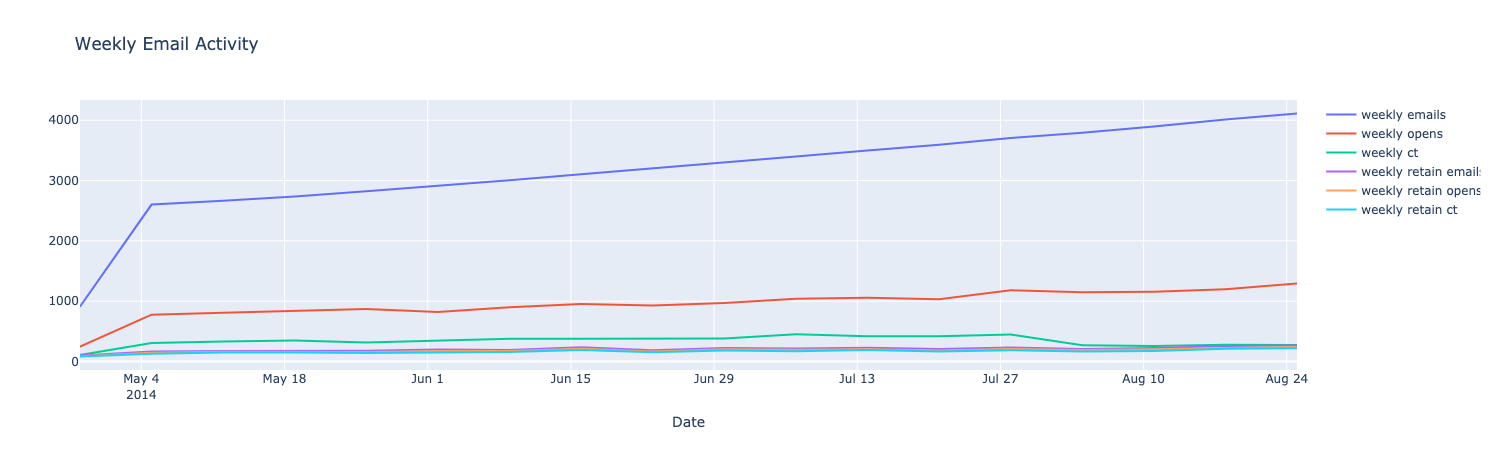

In [29]:
date = email_activity['week']
weekly_emails = email_activity['weekly_emails']
weekly_opens = email_activity['weekly_opens']
weekly_ct = email_activity['weekly_ct']
weekly_retain_emails = email_activity['weekly_retain_emails']
weekly_retain_opens = email_activity['weekly_retain_opens']
weekly_retain_ct = email_activity['weekly_retain_ct']


fig = go.Figure()
fig.add_trace(go.Scatter(x=date, y=weekly_emails,mode='lines',name='weekly emails'))
fig.add_trace(go.Scatter(x=date, y=weekly_opens,mode='lines',name='weekly opens'))
fig.add_trace(go.Scatter(x=date, y=weekly_ct,mode='lines',name='weekly ct'))
fig.add_trace(go.Scatter(x=date, y=weekly_retain_emails,mode='lines',name='weekly retain emails'))
fig.add_trace(go.Scatter(x=date, y=weekly_retain_opens,mode='lines',name='weekly retain opens'))
fig.add_trace(go.Scatter(x=date, y=weekly_retain_ct,mode='lines',name='weekly retain ct'))


fig.update_layout(title='Weekly Email Activity',xaxis_title='Date')

pio.write_html(fig, file='Figures/Weekly_Email_Activity.html',include_plotlyjs='cdn',default_width='60%', default_height='60%')
pio.show(fig)

In [30]:
weekly_rates = pandasql.sqldf("SELECT \
                                    week,\
                                    CAST(weekly_opens as float)/CAST(weekly_emails as float) as open_rate,  \
                                    CAST(weekly_ct as float)/CAST(weekly_opens as float) as ctr, \
                                    CAST(weekly_retain_opens as float)/CAST(weekly_retain_emails as float) as retain_open_rate, \
                                    CAST(weekly_retain_ct as float)/CAST(weekly_retain_opens as float) as retain_ctr \
                              FROM email_activity \
                              ORDER BY 1;", globals()) 
weekly_rates.head()

,week,open_rate,ctr,retain_open_rate,retain_ctr
0,2014-04-28,0.270925,0.426829,0.877551,0.953488
1,2014-05-05,0.298232,0.394330,0.871951,0.895105
2,2014-05-12,0.303565,0.410383,0.925714,0.907407
3,2014-05-19,0.305159,0.417266,0.899441,0.931677
4,2014-05-26,0.307583,0.361751,0.882682,0.879747


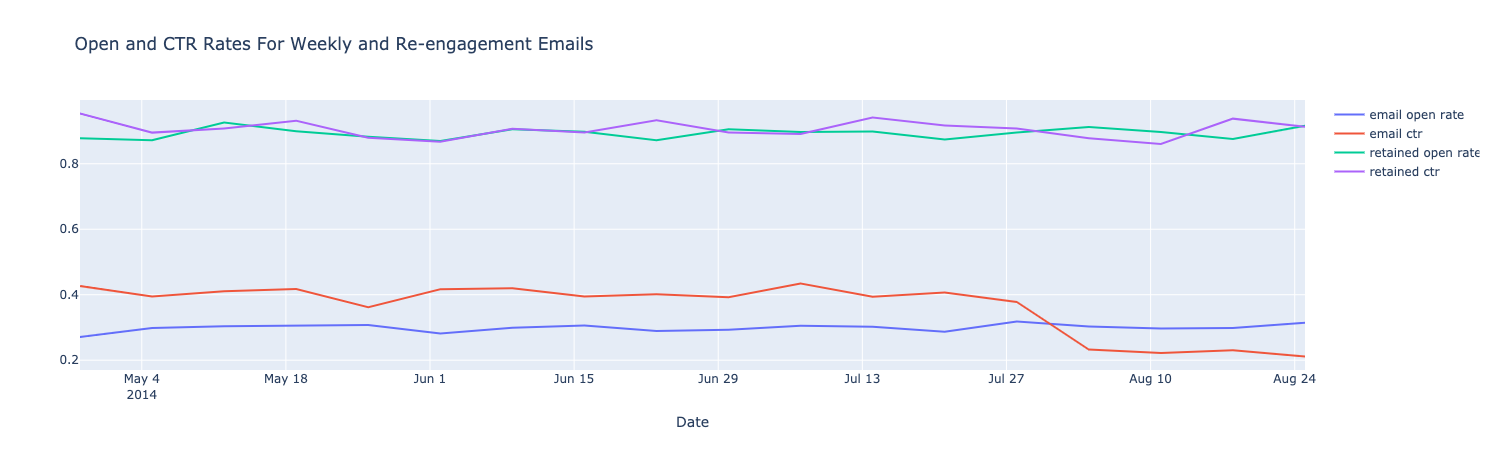

In [31]:
date = weekly_rates['week']
open_rate = weekly_rates['open_rate']
ctr = weekly_rates['ctr']
retain_open_rate = weekly_rates['retain_open_rate']
retain_ctr = weekly_rates['retain_ctr']


fig = go.Figure()
fig.add_trace(go.Scatter(x=date, y=open_rate,mode='lines',name='email open rate'))
fig.add_trace(go.Scatter(x=date, y=ctr,mode='lines',name='email ctr'))
fig.add_trace(go.Scatter(x=date, y=retain_open_rate,mode='lines',name='retained open rate'))
fig.add_trace(go.Scatter(x=date, y=retain_ctr,mode='lines',name='retained ctr'))


fig.update_layout(title='Open and CTR Rates For Weekly and Re-engagement Emails',xaxis_title='Date')

pio.write_html(fig, file='Figures/Open_and_CTR_Rates.html',include_plotlyjs='cdn',default_width='60%', default_height='60%')
pio.show(fig)

##### 7. Engagement by Device/ Product
It is also good to check if the drop in engagement rate is localized to a type of device. We'd want to compare laptops vs phones vs tablets and then perhaps iOS vs androids, or macs vs PCs.

In [32]:
yammer_events['device'].drop_duplicates()

0       dell inspiron notebook
6                     iphone 5
18                   iphone 4s
21             windows surface
23                 macbook air
40                   iphone 5s
50                 macbook pro
55                 kindle fire
58                   ipad mini
71                     nexus 7
79                     nexus 5
81           samsung galaxy s4
89             lenovo thinkpad
103      samsumg galaxy tablet
115       acer aspire notebook
228            asus chromebook
409                    htc one
438            nokia lumia 635
601        samsung galaxy note
635        acer aspire desktop
636                   mac mini
670        hp pavilion desktop
689      dell inspiron desktop
723                   ipad air
1013         amazon fire phone
1753                  nexus 10
Name: device, dtype: object

In [33]:
usage_device = pandasql.sqldf("SELECT   strftime('%Y-%m-%d', occurred_at,'weekday 1','-7 days') as week,\
                                        COUNT(DISTINCT user_id) as 'weekly active users',\
                                        COUNT(DISTINCT CASE WHEN device in ('iphone 5','iphone 4s','iphone 5s','nexus 5','samsung galaxy s4','htc one','nokia lumia 635','samsung galaxy note','amazon fire phone') THEN user_id ELSE NULL END) as 'Phone',\
                                        COUNT(DISTINCT CASE WHEN device in ('windows surface','kindle fire','ipad mini','samsumg galaxy tablet','ipad air','nexus 7','nexus 10') THEN user_id ELSE NULL END) as 'Tablet',\
                                        COUNT(DISTINCT CASE WHEN device in ('dell inspiron notebook','macbook air','macbook pro','lenovo thinkpad','acer aspire notebook','asus chromebook','acer aspire desktop','mac mini','hp pavilion desktop','dell inspiron desktop') THEN user_id ELSE NULL END) as 'Desktop'\
                                    FROM yammer_events\
                                    where event_type='engagement'\
                                    and occurred_at >= '2014-05-01'\
                                    and event_name = 'login'\
                                    GROUP BY 1\
                                    ORDER BY 1;", globals()) 
usage_device.head()

,week,weekly active users,Phone,Tablet,Desktop
0,2014-04-28,825,340,131,504
1,2014-05-05,1077,460,200,712
2,2014-05-12,1145,493,194,752
3,2014-05-19,1148,529,193,741
4,2014-05-26,1140,501,183,745


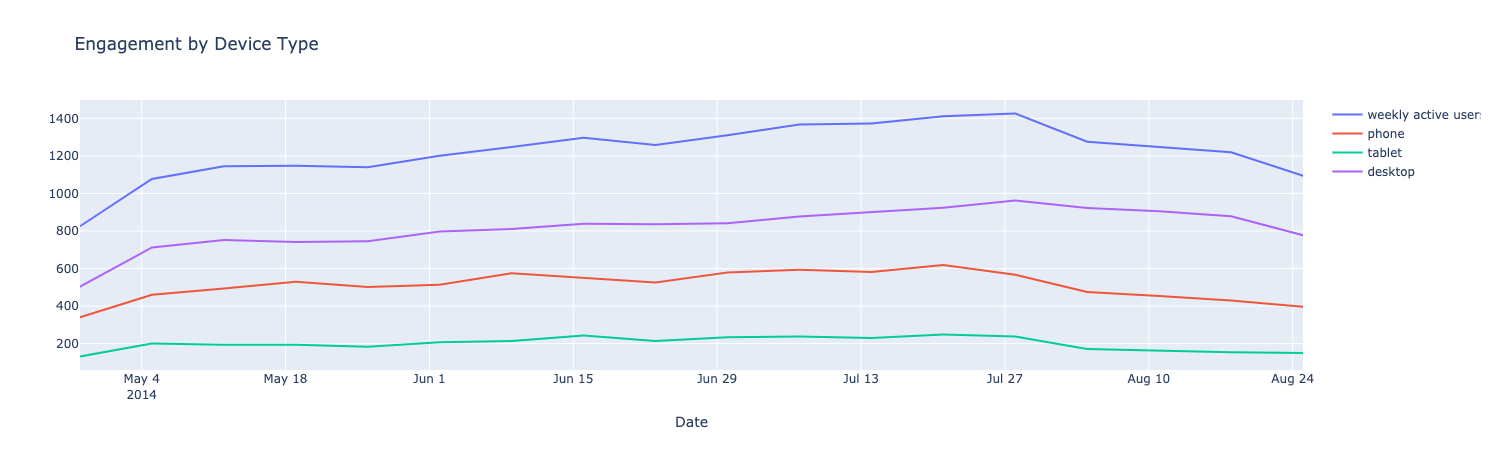

In [34]:
week = usage_device['week']
weekly_active = usage_device['weekly active users']
phone = usage_device['Phone']
tablet = usage_device['Tablet']
desktop = usage_device['Desktop']

fig = go.Figure()
fig.add_trace(go.Scatter(x=week, y=weekly_active,mode='lines',name='weekly active users'))
fig.add_trace(go.Scatter(x=week, y=phone,mode='lines',name='phone'))
fig.add_trace(go.Scatter(x=week, y=tablet,mode='lines',name='tablet'))
fig.add_trace(go.Scatter(x=week, y=desktop,mode='lines',name='desktop'))

fig.update_layout(title='Engagement by Device Type',xaxis_title='Date')

pio.write_html(fig, file='Figures/Engagement_by_Device_Type.html',include_plotlyjs='cdn',default_width='60%', default_height='60%')
pio.show(fig)

In [35]:
usage_phone = pandasql.sqldf("SELECT   strftime('%Y-%m-%d', occurred_at,'weekday 1','-7 days') as week,\
                                        COUNT(DISTINCT CASE WHEN device in ('iphone 5','iphone 4s','iphone 5s') THEN user_id ELSE NULL END) as 'iPhone',\
                                        COUNT(DISTINCT CASE WHEN device in ('nexus 5','samsung galaxy s4','htc one','nokia lumia 635','samsung galaxy note','amazon fire phone') THEN user_id ELSE NULL END) as 'Other'\
                                    FROM yammer_events\
                                    where event_type='engagement'\
                                    and occurred_at >= '2014-05-01'\
                                    and event_name = 'login'\
                                    GROUP BY 1\
                                    ORDER BY 1;", globals()) 
usage_phone.head()

,week,iPhone,Other
0,2014-04-28,155,185
1,2014-05-05,236,224
2,2014-05-12,237,256
3,2014-05-19,261,268
4,2014-05-26,252,249


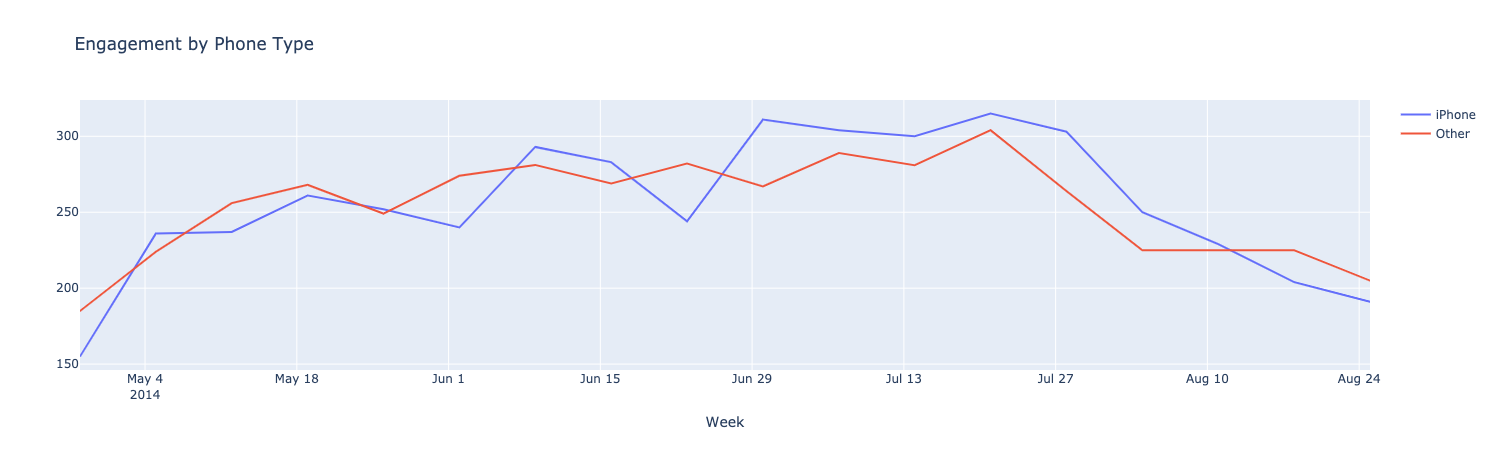

In [36]:
week = usage_phone['week']
iPhone = usage_phone['iPhone']
Other = usage_phone['Other']


fig = go.Figure()
fig.add_trace(go.Scatter(x=week, y=iPhone,mode='lines',name='iPhone'))
fig.add_trace(go.Scatter(x=week, y=Other,mode='lines',name='Other'))

fig.update_layout(title='Engagement by Phone Type',xaxis_title='Week')

pio.write_html(fig, file='Figures/Engagement_by_Phone_Type.html',include_plotlyjs='cdn',default_width='60%', default_height='60%')
pio.show(fig)